### Erzeugung hoher Harmonischer: Wasserstoffatom
In diesem Notebook wird die Erzeugung hoher Harmonischer für ein Wasserstoffatom betrachtet. Die Methode für die Zeitpropagation ist die *Multiphoton-Matrix-Iterative-Methode* aus der Vorlesung (gemäß https://journals.aps.org/pra/pdf/10.1103/PhysRevA.60.3125).
Der stationäre Hamiltonian ist in atomaren Einheiten $$\hat{H}_0 \Psi(\vec{r}, t) = \left(\frac{1}{2}\hat{p}^2 + \hat{V}(\vec{r})\right)\Psi(\vec{r}, t) \quad\Rightarrow\quad \hat{H}_0\Psi_{\ell}(r, t)Y_{\ell,m}(\theta,\varphi) = \left\{-\frac{1}{2 r^2}\frac{\partial}{\partial r}\left(r^2 \frac{\partial}{\partial r} \Psi_{\ell}(r, t) \right) + \frac{\ell(\ell+1)}{2r^2}\Psi_{\ell}(r, t) - \frac{1}{r}\Psi_{\ell}(r, t)\right\}Y_{\ell,m}(\theta,\varphi).$$
Im zweiten Schritt wurde ausgenutzt, dass die sphärischen Harmonischen eine Eigenbasis für die Winkelkomponenten bilden. Daher bleibt zumindest für die statische Schrödingergleichung effektiv eine eindimensionale Betrachtung übrig. Diese kann für den Grundzustand gelöst werden. Um die Matrixnorm zu verringern kann hier, mit Hilfe der Lamé-Koeffizienten, der lineare Ableitungsanteil eliminiert werden. Dazu ersetzen wir $\Psi_{\ell}(r,t)=R_{\ell}(r,t)/r$. Die damit folgenden Randbedingungen sind bei $r=0$ und $r=r_{\text{max}}$ vom Dirichlet-Typ.

Die sich daraus ergebende 1D Gleichung ist $$\text{i}\frac{\partial}{\partial t} R_{\ell}(r, t) = \left\{-\frac{1}{2}\frac{\partial^2}{\partial r^2} R_{\ell}(r, t) + \frac{\ell(\ell+1)}{2r^2}R_{\ell}(r, t) - \frac{1}{r}R_{\ell}(r, t)\right\}.$$

Zur numerischen Behandlung des Problems nutzen wir die Pakete Numpy, Scipy, Matplotlib und die eigens definierten Funktionen in *classes_and_functions*.

In [1]:
%matplotlib widget
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as ssla
import scipy.linalg as sla
import matplotlib.pyplot as plt
from classes_and_functions import calculate_FDM_coefficients_radial, build_derivative_matrices

Nun sollte das statische System gelöst werden. Es wird ein nicht-äquidistantes 1D Gitter mit einer Kombination aus konstantem und linearem Anstieg genutzt, da sich die Eigenfunktionen des Wasserstoffatoms dort sehr gut approximieren lassen und somit eine kleinere Anzahl an Gitterpunkten benötigt werden. Die finite Differenzen Methode ist erster Ordnung, da wir eine Tridiagonale Matrix erhalten wollen. Ausserdem wird sich der Großteil der Wellenfunktion weit vom Kern entfernen, weshalb ein großer maximaler Abstand von nöten ist (hier ca. 455 atomare Einheiten also 24 nm).

The first 10 eigenvalues are:
 [-0.49875621 -0.12492193 -0.05554047 -0.03124551 -0.01999841 -0.01388833
 -0.01020393 -0.00781253 -0.00617295 -0.00500015]
Calculating the first 10 quantum numbers under the exact solution we arrive at (should be around the integers 1 to 10):
 [1.00124611 2.00062485 3.00040743 4.00028736 5.0001984  6.00012163
 7.00005056 7.99998251 8.9999162  9.99985098]
Maximal distance from the center of the atom 455.625 atomic units.


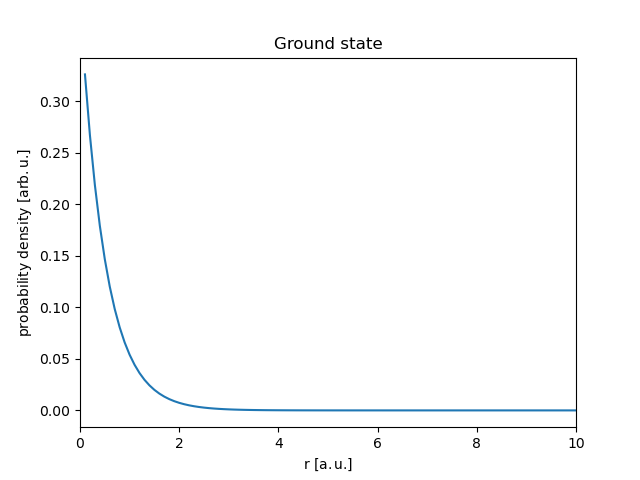

In [2]:
nr = 1250    # number of grid points for the radial part
nr_lin = 100 # number of grid points for the linear radial part
dr = 0.1  # step size of the linear radial grid
lin_rs = dr * np.arange(1, nr_lin + 1) # radial grid with linear spacing
sqr_rs = (dr * np.arange(nr_lin + 1, nr + 1) + dr * nr_lin)**2 / (4 * dr * nr_lin) # radial grid with square spacing
rs = np.concatenate((lin_rs, sqr_rs)) # total radial grid

l = 0       # l for the ground state

# calculation of the first and second derivative matrices including the boundary conditions
from classes_and_functions import calculate_FDM_coefficients_DBC
first, second, drs = calculate_FDM_coefficients_DBC(rs,      order = 1, return_dx = True)
first_deriv        =      build_derivative_matrices( first, len(rs), 1,   neumann = False)
second_deriv       =      build_derivative_matrices(second, len(rs), 1,   neumann = False)

from classes_and_functions import build_jacobi_det_grid
jac = build_jacobi_det_grid(drs, nr, order = 1)

# plot grid points and jacobian to get some idea about the grid
#print(rs[-1], nr_lin * dr)
#plt.figure()
#plt.plot(rs)
#plt.show()

#plt.figure()
#plt.plot(jac)
#plt.show()

pot     = -ssp.diags(1 / rs) # Coulomb potential
kin_r   = -0.5 * second_deriv  # kinetic energy
def kin_ang(l):
    return 0.5 * ssp.diags(l * (l + 1) / rs**2)

H0 = kin_r + kin_ang(l) + pot # total static Hamiltonian

evals, evecs = ssla.eigs(H0, k = 10, which = 'SR', maxiter = 1e7)#sla.eig(H0.todense()) # exact diagonalization of the 1D system for l=0 #
# sorting eigenvalues and eigenvectors starting from the smallest
evals = evals.real
ids_sort = np.argsort(evals)
evals = evals[ids_sort]
evecs = evecs[:, ids_sort]

print("The first 10 eigenvalues are:\n", evals[:10])
print("Calculating the first 10 quantum numbers under the exact solution we arrive at (should be around the integers 1 to 10):\n", 1 / np.sqrt(-2 * evals[:10]))
print("Maximal distance from the center of the atom {} atomic units.".format(rs[-1]))
# Plot the ground state of the channel l=0
plt.figure()
plt.plot(rs, np.abs(evecs[:, 0] / rs)**2)
plt.xlabel("r [a.$\,$u.]")
plt.ylabel("probability density [arb.$\,$u.]")
plt.title("Ground state")
plt.xlim(0, 10)
plt.show()

Für die Kopplung an ein externes linear polarisiertes Feld in z-Richtung müssen die Matrixelemente des dynamischen Hamiltonians in der Basis bestimmt werden. Dafür benötigt man die sogenannten Kosinusintegrale die in der Funktion Cll zusammengefasst werden. Der radiale Anteil bleibt dabei in spärlicher Matrixform. Da die Anregung keine magnetische Quantenzahl ändern kann, wird diese auf 0 fixiert. Ein Maximum der Nebenquantenzahl lmax wird festgelegt und auf Konvergenz überprüft. Für die iterative Method wird eine maximale Anzahl der Iterationen gesetzt. Desweiteren werden die folgenden Parameter gesetzt:
- zentrale Pulsfrequenz omega
- Zahl an optischen Zyklen Nopt
- Amplitude des elektrischen Feldes E_0
- Anzahl der Zeitschritte nt

In [3]:
lmax       =  6   # max azimuthal quantum number
N_iter_max = 50   # max number of iterations
nt         = 10001 # number of time steps
omega      = 1.0  # central pulse frequency
Nopt       = 15   # number of optical cycles
E_0        = np.sqrt(2 * 3.5e20 / (8.854e-12 * 3e8)) / 5.142207e11 # electric field strength

t_end = Nopt * 2 * np.pi / omega # pulse end time
ts = np.linspace(0, t_end, nt)   # times of evaluation and propagation
dt = ts[1] - ts[0]               # time step
print(dt)

# cosine matrix elements
def Cll(l1, l2):
    if l2 == l1 + 1:
        return (l1 + 1) / np.sqrt((2 * l1 + 3) * (2 * l1 + 1))
    elif l2 == l1 - 1:
        return l1 / np.sqrt((2 * l1 + 1) * (2 * l1 - 1))
    else:
        return 0


0.00942477796076938


Die Pulsform ist für das elektrische Feld bekannt, da es durch die Einhüllende festgelegt wird. Jedoch benötigt man in der Geschwindigkeitseichung das magnetische Vektorpotential, welches in der Weyl-Eichung dem negativen zeitlichen Integral entspricht. Dieses Integral wird im Folgenden unter zuhilfenahme einer Quadratur berechnet.

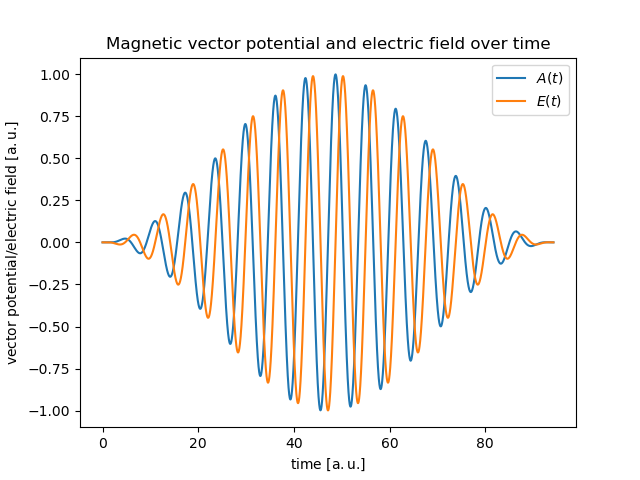

In [4]:
from classes_and_functions import venvelope
from scipy.integrate import quad

def Et(t):
    return E_0 * venvelope(t, t_end) * np.cos(omega * t)

As = np.empty((nt,), dtype = np.float64)
As[0] = 0.0
for i_t, t in enumerate(ts[1:]):
    As[i_t + 1] = As[i_t] - quad(Et, ts[i_t], ts[i_t + 1])[0]

plt.figure()
plt.plot(ts, As, label = "$A(t)$")
plt.plot(ts, Et(ts), label = "$E(t)$")
plt.xlabel("time [a.$\,$u.]")
plt.ylabel("vector potential/electric field [a.$\,$u.]")
plt.title("Magnetic vector potential and electric field over time")
plt.legend()
plt.show()

Die Matrixrepräsentation des diagonalen (OD) und nicht diagonalen (OND) Operators wird, aufgrund der finiten Differenzen Methode mit 3 Punkten, tridiagonal. ODb beinhaltet die Diagonalen des Operators OD, damit später das lineare Gleichungssystem für n-diagonale Matrizen mit einem dafür konzipierten Algorithmus gelöst werden kann. Die Nebendiagonalen Operatoren werden wegen der Übersichtlichkeit in einem Python *dictionary* gespeichert.

In [5]:
OND = {}
ODb = np.empty((lmax, 3, nr), dtype = np.complex128)
for l1 in range(lmax):
    OD = ssp.eye(H0.shape[0]) + dt * 0.5j * (kin_r + kin_ang(l1) + pot)

    ODb[l1, 0] = np.concatenate(([0],OD.diagonal(1)))
    ODb[l1, 1] = OD.diagonal(0)
    ODb[l1, 2] = np.concatenate((OD.diagonal(-1), [0]))

    for l2 in range(lmax):
        if l1 != l2:
            Hkk = -1j * Cll(l1, l2) * (first_deriv + ssp.diags((l1 * (l1 + 1) - l2 * (l2 + 1)) / (2 * rs)))
            OND[(l1, l2)] = 0.5j * Hkk * dt


Nun wird der Algorithmus umgesetzt und die Observablen in der Zeit bestimmt. Dafür wird alles Funktional gehalten und für die Übersichtlichkeit *typing* benutzt. Die Zelle hat auf meinem Computer für ca. 2 min gerechnet.

In [6]:
invrs2 = 1 / rs**2
def calculate_acceleration_dipole_moment(bk: dict) -> float:
    """
    Calculation of the acceleration of the dipole moment in z-direction as in the referenced paper.
    """
    acc_d = 0
    for l1 in range(lmax):
        for l2 in range(lmax):
            cll = Cll(l1, l2)
            if cll != 0:
                acc_d += bk[l1].conj().dot(jac * invrs2 * bk[l2])
    return acc_d

def calculate_dipole_moment(bk: dict) -> float:
    """
    Calculation of the dipole moment in z-direction by the integration of r * cos(theta) (cosine integrals).
    """
    d_mom = 0
    for l1 in range(lmax):
        for l2 in range(lmax):
            cll = Cll(l1, l2)
            if cll != 0:
                d_mom += bk[l1].conj().dot(jac * rs * bk[l2])
    return d_mom

def calculate_prob_density(bk):
    """
    Calculation of the radial probability density |R_l(r, t)|^2 for the animation.
    """
    Rr = np.zeros((nr,), dtype = np.float64)
    for l in range(lmax):
        Rr += np.abs(bk[l])**2
    return Rr


def iteration(i_t: int, l1: int, bkm1: dict) -> np.ndarray:
    """
    One single iteration step for the next beta. The commented lines are the general way, while the other lines are the special case of the linear polarized field.
    """
    bk = np.zeros((nr,), dtype = np.complex128)
    #for l2 in range(lmax):
    #    if l1 != l2:
    #        bk -= OND[(l1, l2)].dot(bkm1[l2])
    if l1 != lmax - 1:
        bk -= OND[(l1, l1 + 1)].dot(bkm1[l1 + 1])
    if l1 > 0:
        bk -= OND[(l1, l1 - 1)].dot(bkm1[l1 - 1])
    return sla.solve_banded((1, 1), ODb[l1], As[i_t] * bk)

def create_phik(i_t: int, l1: int, bk: dict) -> np.ndarray:
    """
    Calculation of the initial phi_k for b_0. The commented lines are the general way, while the other lines are the special case of the linear polarized field.
    """
    phik = bk[l1]
    #for l2 in range(lmax):
    #    if l1 != l2:
    #        phik -= As[i_t] * OND[(l1, l2)].dot(bk[l2])
    if l1 != lmax - 1:
        phik -= As[i_t] * OND[(l1, l1 + 1)].dot(bk[l1 + 1])
    if l1 > 0:
        phik -= As[i_t] * OND[(l1, l1 - 1)].dot(bk[l1 - 1])
    return phik

def time_step(i_t: int, bk: dict) -> dict:
    """
    A single time step of the algorithm.
    Input:
        i-th time step (int): i_t
        basis coefficients (dict): bk
    Output:
        basis coefficients of next time step (dict): bknew
    """
    tol   = 1e-30 # tolerance at which the iterative method has its break point
    bknew = {} # basis coefficents of the next time step
    bk0   = {} # zeroth element of the iterative method
    beta1 = {} # element of the iterative method
    beta2 = {} # element of the iterative method
    for l1 in range(lmax):
        phik = create_phik(i_t, l1, bk)
        bk0[l1]  = sla.solve_banded((1, 1), ODb[l1], phik)
    for l1 in range(lmax):
        beta1[l1] = iteration(i_t, l1, bk0)
        bknew[l1] = bk0[l1] + beta1[l1] # setting bknew with the zeroth and first iteration element
    for _ in range(1, N_iter_max):
        error = 0.0 # error for the tolerance measure
        for l1 in range(lmax):
            beta2[l1] = iteration(i_t, l1, beta1)
            bknew[l1] += beta2[l1] # add next iteration to bknew
            error += np.linalg.norm(beta2[l1])
        if error < tol:
            break
        for l1 in range(lmax):
            beta1[l1] = beta2[l1].copy() # setting the old iteration element with new one
    return bknew
    

def run_sim(bk: dict, Rr_t: np.ndarray, dip: np.ndarray, acc_dip: np.ndarray):
    """
    Run the simulation and override the observables.
    Input:
        basis coefficients (empty dict): bk (gets initialized)
        radial function over time (numpy array): Rr_t
        dipole moment over time (numpy array): dip
        acceleration of the dipole moment over time (numpy array): acc_dip
    Output:
        None
    """
    for l1 in range(lmax):
        if l1 == 0:
            bk[l1] = evecs[:, 0].astype(np.complex128)
        else:
            bk[l1] = np.zeros((nr,), dtype = np.complex128)

    # calculate the observables at time t=0
    acc_dip[0] = calculate_acceleration_dipole_moment(bk)
    dip[0]     = calculate_dipole_moment(bk)
    Rr_t[0]    = calculate_prob_density(bk)
    # start the propagation
    for i_t in range(1, nt):
        bk = time_step(i_t, bk)
        # calculate the observables at time t
        acc_dip[i_t] = calculate_acceleration_dipole_moment(bk)
        dip[i_t]     = calculate_dipole_moment(bk)
        Rr_t[i_t]    = calculate_prob_density(bk)
    return
    

bk = {}
acc_dip = np.empty((nt,), dtype = np.complex128)
dip     = np.empty((nt,), dtype = np.complex128)
Rr_t    = np.empty((nt, nr), dtype = np.float64)
run_sim(bk, Rr_t, dip, acc_dip)



Im folgenden kann die radiale Wahrscheinlichkeitsdichte in einer Animation und die Observablen in einem Graphen dargestellt werden.

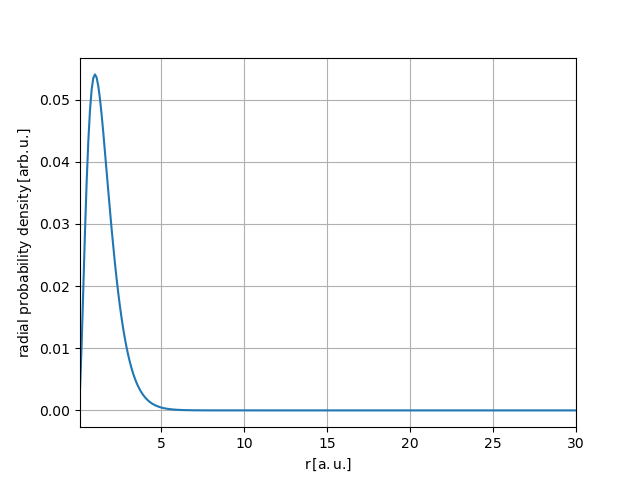

In [7]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

line, = ax.plot(rs, Rr_t[0])
plt.xlim(rs[0], 30)
plt.xlabel("r$\,$[a.$\,$u.]")
plt.ylabel("radial probability density$\,$[arb.$\,$u.]")
plt.grid()

def init():
    line.set_ydata([np.nan] * nr)
    return line,

def animate(i):
    line.set_ydata(Rr_t[i])  # update the data.
    return line,

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True)#, save_count=50)

plt.show()

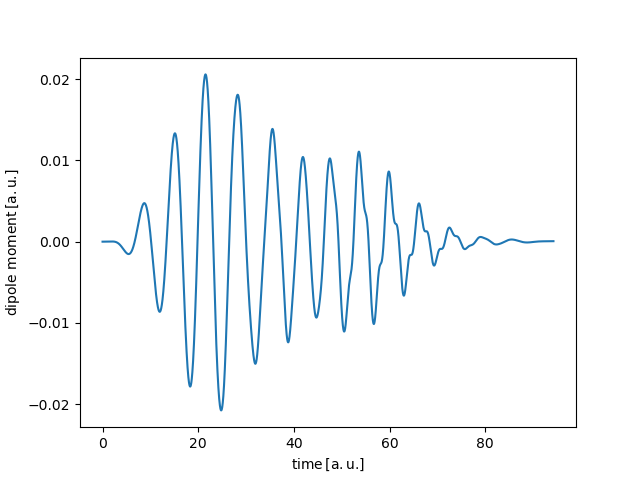

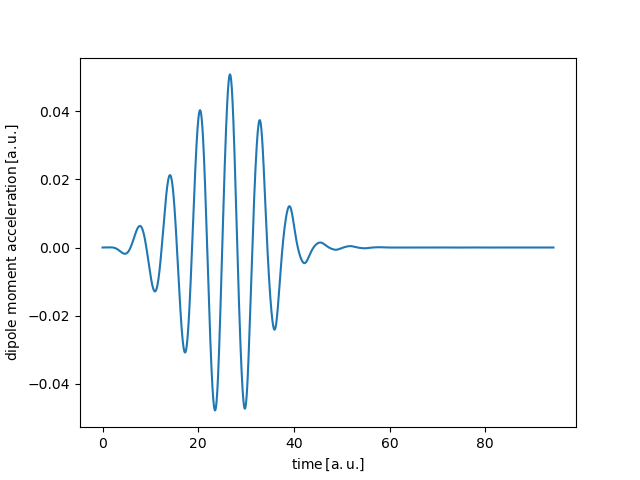

In [8]:
plt.figure()
plt.plot(ts, dip.real)
plt.xlabel("time$\,$[a.$\,$u.]")
plt.ylabel("dipole moment$\,$[a.$\,$u.]")
plt.show()

plt.figure()
plt.plot(ts, acc_dip.real)
plt.xlabel("time$\,$[a.$\,$u.]")
plt.ylabel("dipole moment acceleration$\,$[a.$\,$u.]")
plt.show()

Nach der Bestimmung der Beschleunigung des Dipolmoments kann auch das Spektrum der Abstrahlung mit einer Fouriertransformation berechnet werden.

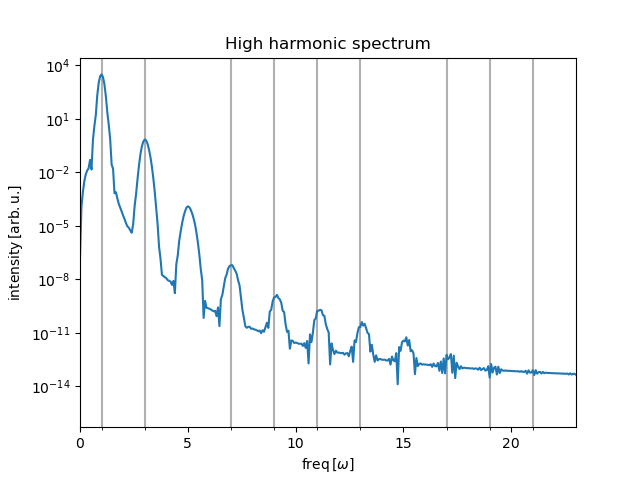

In [9]:
fft_acc_dip = np.abs(np.fft.fft(acc_dip))**2
freq = np.fft.fftfreq(nt, d=dt)
sort_freq = np.argsort(freq)
omegas = 2 * np.pi * freq[sort_freq]
fft_acc_dip = fft_acc_dip[sort_freq]

# plot of the high harmonic spectrum
fig, ax = plt.subplots()
plt.title("High harmonic spectrum")
plt.plot(np.real(omegas / omega), fft_acc_dip)
ax.set_yscale('log')
ax.set_xlabel("freq$\,$[$\omega$]")
ax.set_ylabel("intensity$\,$[arb.$\,$u.]")
plt.xlim(0, 23)
minor_ticks = np.arange(1, 23, 2)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(which = 'minor', linewidth = 1.5, axis = 'x')
plt.show()

Die Rechnungen befinden sich weder im von Multiphotonen dominierten Bereich noch in dem der Tunnelionisation. Das erkennt man an dem Keldyshparameter, da er weder viel kleiner noch viel größer als 1 ist. Siehe dazu folgende Code-Zelle.

In [10]:
Up = E_0**2 / (4 * omega**2) # ponderomotive energy
Ip = -evals[0] # ionisation energy
keldysh = np.sqrt(Ip / (2 * Up))
print("Keldysh parameter:", keldysh)
print("Cutoff:", (3.17 * Up + Ip) / omega)

Keldysh parameter: 1.0004377661087316
Cutoff: 1.288593126890669
